**Question 2:**

**Part A, Decision Tree:**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import numpy as np
from sklearn import preprocessing
import random
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
train = pd.read_csv('/content/drive/MyDrive/titanic-train.csv')

First, I implement a preprocessing on the data as below:

In [3]:
encoder = preprocessing.LabelEncoder()

In [4]:
def prepro(data, isTest):
    try:
        data['Age'] = data['Age'].fillna(data['Age'].median())
        data['Fare'] = data['Fare'].fillna(data['Fare'].median())
        data['Embarked'] = data['Embarked'].fillna('S')
        data['Sex'] = encoder.fit_transform(data['Sex'])  
    except KeyError as e:
        print('Invalid preprocess')
        print(e)
    return data

In [5]:
train = prepro(train, True)

In [6]:
categorical_cols = [col for col in train.columns if
                   train[col].nunique() < 10 and
                   train[col].dtype == 'object'
                   ]
numerical_cols = [col for col in train.columns if train[col].dtype in ['int64', 'float64']]
df = pd.get_dummies(train)

In [7]:
label = df['Survived']
df = df.drop(['Survived'], axis=1)
df = pd.concat([df,label],axis=1)

Next, I split the data into train and test sets as below:

In [8]:
def split_dataset(X, y, split_size = 0.8):
    size = len(X)
    x_train = X[: int(size * split_size), :]
    y_train = y[: int(size * split_size)]
    x_test = X[int(size * split_size) :, :]
    y_test = y[int(size * split_size) :]
    return x_train, x_test, y_train, y_test  

In [9]:
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values
attributes = df.columns.values[:-1]
x_train, x_test, y_train, y_test = split_dataset(X, y)

Implementation of the decision tree using class in Python:

In [10]:
class Node:

    def __init__(self, feature=None, threshold=None, left=None, right=None,*,value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
        
    def is_leaf_node(self):
        return self.value is not None

In [11]:
class DecisionTree:

    def __init__(self, min_samples_split=2, max_depth=100, n_features=None):
        self.min_samples_split=min_samples_split
        self.max_depth=max_depth
        self.n_features=n_features
        self.root=None

    def _calcEntropy(self, y):
        n = np.bincount(y)
        prob = n / len(y)
        entropy_ = - np.sum(prob * np.log2(prob))
        return entropy_

    def _calcInformationGain(self, y, X_column, threshold):
        parent_entropy = self._calcEntropy(y)
        left_idxs, right_idxs = self.split(X_column, threshold)
        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = self._calcEntropy(y[left_idxs]), self._calcEntropy(y[right_idxs])
        child_entropy = (n_l/n) * e_l + (n_r/n) * e_r
        information_gain = parent_entropy - child_entropy
        return information_gain


    def fit(self, X, Y):
        self.n_features = X.shape[1] if not self.n_features else min(X.shape[1],self.n_features)
        self.root = self.tree_add(X, Y)

    def tree_add(self, X, Y, depth=0):
        n_samples, n_feats = X.shape
        n_labels = len(np.unique(Y))

        if (depth>=self.max_depth or n_labels==1 or n_samples<self.min_samples_split):
            leaf_value = self.most_common(Y)
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_feats, self.n_features, replace=False)
        best_feature, best_thresh = self.best_split(X, Y, feat_idxs)

        left_idxs, right_idxs = self.split(X[:, best_feature], best_thresh)
        left = self.tree_add(X[left_idxs, :], Y[left_idxs], depth+1)
        right = self.tree_add(X[right_idxs, :], Y[right_idxs], depth+1)
        return Node(best_feature, best_thresh, left, right)


    def best_split(self, X, y, feat_idxs):
        split_idx, split_threshold = None, None
        best_gain = -1

        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)

            for thr in thresholds:
                gain = self._calcInformationGain(y, X_column, thr)
                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_threshold = thr

        return split_idx, split_threshold

    
    def split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def most_common(self, y):
        labels, labels_count = np.unique(y, return_counts=True)
        if len(labels) == 0:
            return np.random.randint(0,2)
        value = labels[np.argmax(labels_count)]
        return value

    def recursive_tree(self, x, node):
        if node.is_leaf_node():
            return node.value
        if x[node.feature] <= node.threshold:
            return self.recursive_tree(x, node.left)
        else:
            return self.recursive_tree(x, node.right)
    
    def predict(self, X):
        return np.array([self.recursive_tree(x, self.root) for x in X])

Defining two functions for the Confusion Matrix:

In [12]:
def confusion_matrix(y_test, y_pred):
    matrix = np.array([[0,0],
                  [0,0]])
    for i in range(len(y_test)):
        temp = [y_test[i],y_pred[i]]
        if temp == [0,0]:
            matrix[0][0]+=1
        elif temp == [0,1]:
            matrix[0][1]+=1
        elif temp == [1,0]:
            matrix[1][0]+=1
        elif temp == [1,1]:
            matrix[1][1]+=1
    return matrix

In [13]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Defining an evaluation function to calculate the accuracy and Confusion Matrix:

In [14]:
def result (depth, x_train, y_train, y_test):
    clf = DecisionTree(max_depth = depth)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    accuracy = np.sum(y_pred == y_test) / len(y_pred) * 100
    print('Accuracy = ',accuracy)
    confusion_mtx = confusion_matrix(y_test, y_pred)
    classes = np.unique(df.iloc[:, -1].values)
    plot_confusion_matrix(confusion_mtx, classes)

For depth = 3:

<ipython-input-11-c2d4d0d70466>:12: RuntimeWarning: divide by zero encountered in log2
  entropy_ = - np.sum(prob * np.log2(prob))
<ipython-input-11-c2d4d0d70466>:12: RuntimeWarning: invalid value encountered in multiply
  entropy_ = - np.sum(prob * np.log2(prob))


Accuracy =  82.68156424581005


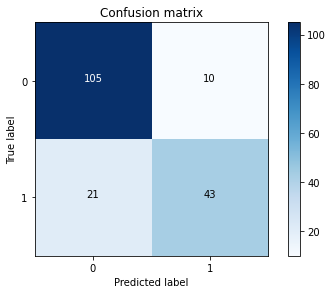

In [15]:
depth = 3
result (depth, x_train, y_train, y_test)

For depth = 5:

<ipython-input-11-c2d4d0d70466>:12: RuntimeWarning: divide by zero encountered in log2
  entropy_ = - np.sum(prob * np.log2(prob))
<ipython-input-11-c2d4d0d70466>:12: RuntimeWarning: invalid value encountered in multiply
  entropy_ = - np.sum(prob * np.log2(prob))


Accuracy =  83.79888268156425


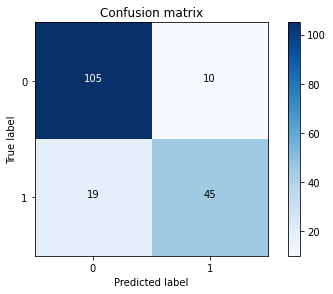

In [16]:
depth = 5
result (depth, x_train, y_train, y_test)

For depth = 7:

<ipython-input-11-c2d4d0d70466>:12: RuntimeWarning: divide by zero encountered in log2
  entropy_ = - np.sum(prob * np.log2(prob))
<ipython-input-11-c2d4d0d70466>:12: RuntimeWarning: invalid value encountered in multiply
  entropy_ = - np.sum(prob * np.log2(prob))


Accuracy =  81.56424581005587


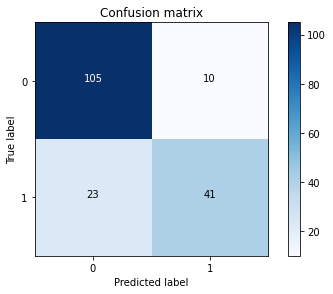

In [17]:
depth = 7
result (depth, x_train, y_train, y_test)

For depth = 9:

<ipython-input-11-c2d4d0d70466>:12: RuntimeWarning: divide by zero encountered in log2
  entropy_ = - np.sum(prob * np.log2(prob))
<ipython-input-11-c2d4d0d70466>:12: RuntimeWarning: invalid value encountered in multiply
  entropy_ = - np.sum(prob * np.log2(prob))


Accuracy =  80.44692737430168


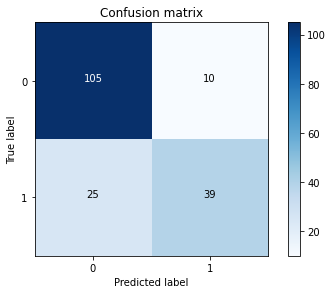

In [18]:
depth = 9
result (depth, x_train, y_train, y_test)

For depth = 11:

<ipython-input-11-c2d4d0d70466>:12: RuntimeWarning: divide by zero encountered in log2
  entropy_ = - np.sum(prob * np.log2(prob))
<ipython-input-11-c2d4d0d70466>:12: RuntimeWarning: invalid value encountered in multiply
  entropy_ = - np.sum(prob * np.log2(prob))


Accuracy =  79.88826815642457


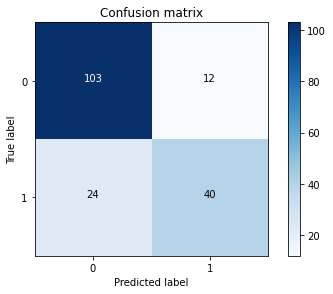

In [19]:
depth = 11
result (depth, x_train, y_train, y_test)

As we see, at some depth the algorithm overfits, and the accuracy does not improve constantly.

**Part B:**

**Random Forest**

Functions for implementation of the Random Forest, and evaluating the results:

In [20]:
def RandomForest(x_train, y_train, x_test, num_tree):
  y_pred = np.zeros((len(y_test),num_tree))
  for i in range (num_tree):
    new_tree = DecisionTree(max_depth = random.randint(3, 9))
    new_tree.fit(x_train,y_train)
    y_pred[:,i] = new_tree.predict(x_test)

  y_predicted = np.zeros(len(y_test))
  for i in range(len(x_test)):
    unique_vals, counts = np.unique(y_pred[i], return_counts = True)
    y_predicted[i] = unique_vals[np.argmax(counts)]
  return y_predicted
    

In [21]:
def RandomForest_result (num_tree, x_train, y_train, y_test):
  y_pred = RandomForest(x_train, y_train, x_test, num_tree)
  accuracy = np.sum(y_pred == y_test) / len(y_pred) * 100
  print('Accuracy = ',accuracy)
  confusion_mtx = confusion_matrix(y_test, y_pred)
  classes = np.unique(df.iloc[:, -1].values)
  plot_confusion_matrix(confusion_mtx, classes)

For num_tree = 3:

<ipython-input-11-c2d4d0d70466>:12: RuntimeWarning: divide by zero encountered in log2
  entropy_ = - np.sum(prob * np.log2(prob))
<ipython-input-11-c2d4d0d70466>:12: RuntimeWarning: invalid value encountered in multiply
  entropy_ = - np.sum(prob * np.log2(prob))


Accuracy =  83.24022346368714


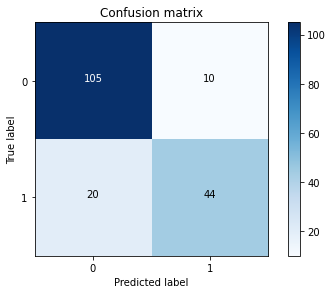

In [22]:
num_tree = 3
RandomForest_result (num_tree, x_train, y_train, y_test)

For num_tree = 5:

<ipython-input-11-c2d4d0d70466>:12: RuntimeWarning: divide by zero encountered in log2
  entropy_ = - np.sum(prob * np.log2(prob))
<ipython-input-11-c2d4d0d70466>:12: RuntimeWarning: invalid value encountered in multiply
  entropy_ = - np.sum(prob * np.log2(prob))


Accuracy =  81.56424581005587


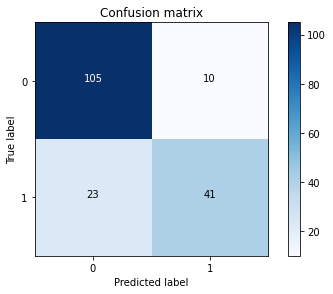

In [23]:
num_tree = 5
RandomForest_result (num_tree, x_train, y_train, y_test)

For num_tree = 7:

<ipython-input-11-c2d4d0d70466>:12: RuntimeWarning: divide by zero encountered in log2
  entropy_ = - np.sum(prob * np.log2(prob))
<ipython-input-11-c2d4d0d70466>:12: RuntimeWarning: invalid value encountered in multiply
  entropy_ = - np.sum(prob * np.log2(prob))


Accuracy =  83.79888268156425


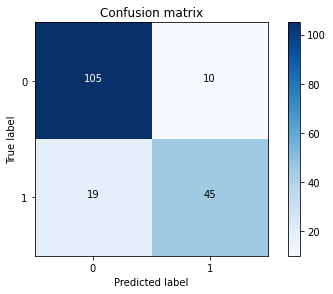

In [24]:
num_tree = 7
RandomForest_result (num_tree, x_train, y_train, y_test)

As we see, by increasing the number of trees, the accuracy improves, which is expected in the ensemble learning algorithms.